In [1]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import gc
import jax, sys
import importlib

In [2]:
sys.path = ['../'] + sys.path

In [3]:
from jax_lensing import wiener_sampling, spectral, inversion
importlib.reload(wiener_sampling)
importlib.reload(spectral)
importlib.reload(inversion)

<module 'jax_lensing.inversion' from '../jax_lensing/inversion.py'>

In [4]:
from astropy.io import fits

In [5]:
test_e = fits.open('../data/ktng/ktng_cosmos_e360.fits')
test_e = test_e[0].data
test_kappa = fits.open('../data/ktng/ktng_cosmos_kappa360.fits')
test_kappa = test_kappa[0].data
mask = fits.open('../data/COSMOS/cosmos_full_mask_0.29arcmin360.fits')
mask = mask[0].data

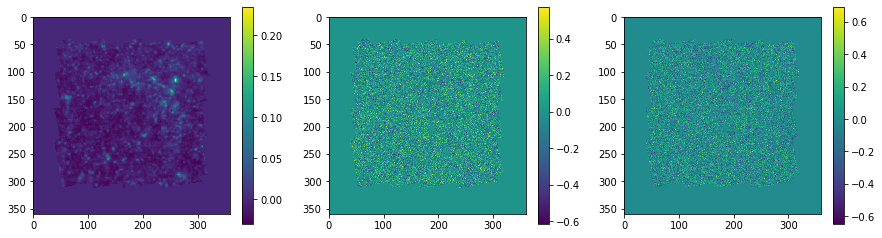

In [6]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa*mask), plt.colorbar()
_ = plt.subplot(132), plt.imshow(test_e[:,:,0]), plt.colorbar()
_ = plt.subplot(133), plt.imshow(test_e[:,:,1]), plt.colorbar()

In [7]:
std_e1 = 0.148
ncov_diag_e1 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e3
ncov_diag_e2 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e3

In [10]:
ps = spectral.measure_power_spectrum(test_kappa+1j*test_kappa*0.)
ps_map = jnp.fft.fftshift(spectral.make_power_map(ps,360))

In [11]:
wf_e1, wf_e2 = wiener_sampling.spin_wiener_filter(test_e[:,:,0]+1j*test_kappa*0., test_e[:,:,1]+1j*test_kappa*0., ncov_diag_e1,ncov_diag_e2, ps_map, ps_map*0., iterations=20)
wf_e, wf_b = inversion.ks93(wf_e1, wf_e2)

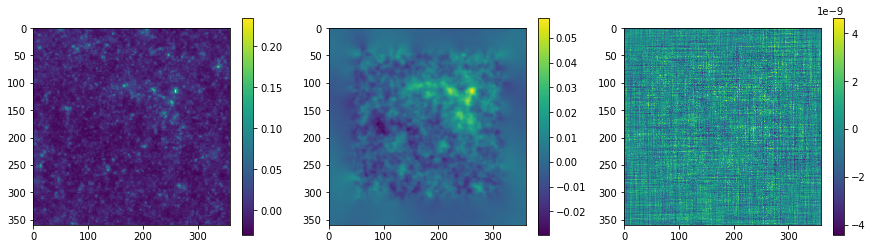

In [12]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_e), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_b), plt.colorbar()

In [26]:
wf_samples_e,wf_samples_b  = wiener_sampling.spin_wiener_sampler(test_e[:,:,0], test_e[:,:,1], ncov_diag_e1,ncov_diag_e2, ps_map, ps_map*0., iterations=1000, thinning=5)

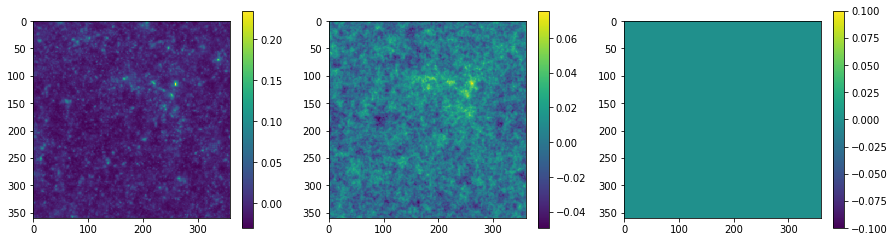

In [27]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_samples_e[35].real), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_samples_b[35].real), plt.colorbar()

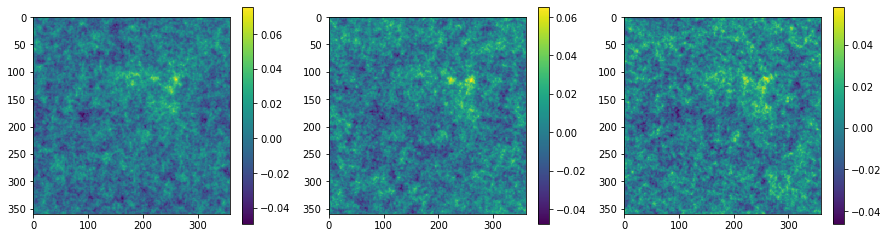

In [28]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(wf_samples_e[35]), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_samples_e[36]), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_samples_e[37]), plt.colorbar()

In [29]:
mean_samples = np.mean(wf_samples_e, axis=0)
std_samples = np.std(wf_samples_e, axis=0)

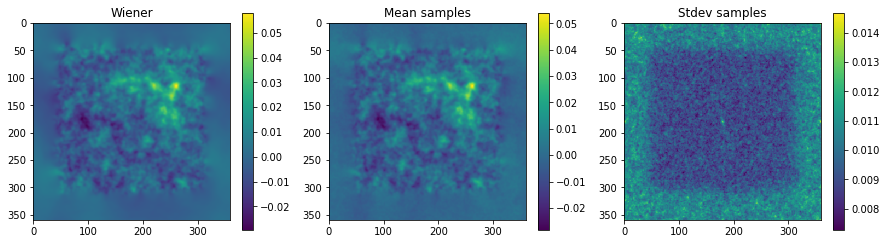

In [30]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(wf_e), plt.title('Wiener'), plt.colorbar()
_ = plt.subplot(132), plt.imshow(mean_samples), plt.title('Mean samples'),  plt.colorbar()
_ = plt.subplot(133), plt.imshow(std_samples), plt.title('Stdev samples'),  plt.colorbar()

# Problem with sampler - getting a mode in the middle